Importamos los paquetes necesarios

In [2]:
import cv2
import imutils
import numpy as np
from pyzbar import pyzbar
import matplotlib.pyplot as plt

Cargamos nuestras imagenes

In [3]:
# img = cv2.imread('img/test/barcode_detector_test_025565.jpg', cv2.IMREAD_COLOR) #1º
# img = cv2.imread('img/test/Barcodes_val_010985.jpg', cv2.IMREAD_COLOR) #-45º
# img = cv2.imread('img/test/barcode_detector_train_025407.jpg', cv2.IMREAD_COLOR) #87º
# img = cv2.imread('img/test/thisisnotgood_val_016289.jpg', cv2.IMREAD_COLOR) #-23º
img = cv2.imread('img/train/barcode_detector_test_025552.jpg', cv2.IMREAD_COLOR) #133º
# img = cv2.imread('images/barcode_01.jpg', cv2.IMREAD_COLOR) #47º
# img = cv2.imread('images/barcode_02.jpg', cv2.IMREAD_COLOR) #-23º
# img = cv2.imread('images/barcode_03.jpg', cv2.IMREAD_COLOR) #-45º
# img = cv2.imread('images/barcode_04.jpg', cv2.IMREAD_COLOR) #87º
# img = cv2.imread('images/barcode_05.jpg', cv2.IMREAD_COLOR) #-133º
# img = cv2.imread('images/barcode_06.jpg', cv2.IMREAD_COLOR) #1º

Un poco debug sucio

In [4]:
print(img.shape[1])

1600


Definimos los factores de escala y redimensionamos la imagen

In [5]:
if 1600 > img.shape[1] > 1000:
    scale_x = 0.3
    scale_y = 0.3
elif img.shape[1] >= 1600:
    scale_x = 0.25
    scale_y = 0.25
else:
    scale_x = 1
    scale_y = 1

# Redimensionar la imagen utilizando factores de escala
resized_image = cv2.resize(img, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_AREA)

Convertimos a escala de grises

In [6]:
gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
cv2.imshow('Bordes Canny', gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

Calculamos la representacion de magnitud gradiente de Sharr de las imagenes en los dos ejes

In [7]:
gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)

# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)
cv2.imshow('Gradient', gradient)
cv2.waitKey(0)
cv2.destroyAllWindows()

Rotacion fallida

In [8]:
# # Aplicar el detector de bordes Canny
# bordes = cv2.Canny(gray, 10, 240, L2gradient = True)

# # Mostrar los bordes detectados
# cv2.imshow('Bordes Canny', bordes)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # Transformada de Hough para detectar líneas
# lines = cv2.HoughLinesP(bordes, 1, np.pi/180, 40, minLineLength=30, maxLineGap=15)

# # Vamos a obter la orientación dominante de las líneas detectadas
# if lines is not None:
#     all_angles = []
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         dx = x2-x1
#         dy = y2-y1
#         angle = np.degrees(np.arctan2(dy, dx))
#         all_angles.append(angle)

#     dominant_angle = np.median(all_angles)

#     if -90 <= dominant_angle < 0:
#         rotacion = dominant_angle #-47º
#     elif 0 <= dominant_angle < 90:
#         rotacion = 90 - dominant_angle #47º
#     elif -180 < dominant_angle < -90:
#         rotacion = (180 + dominant_angle) + 90 #-133º
#     else:
#         rotacion = 90 - (180 - dominant_angle) #133º

# # Calculamos el centro de la imagen para la rotación
# alto, ancho = resized_image.shape[0:2]
# centro = (ancho // 2, alto // 2)
# angulo = rotacion
# escala = 1.0

# # Matriz de rotacion
# matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo, escala)

# # Aplicamos la rotacion
# imagen_rotada = cv2.warpAffine(resized_image, matriz_rotacion, (ancho, alto))

# # Mostrar la imagen con las líneas detectadas
# cv2.imshow('Deteccion de lineas', imagen_rotada)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [9]:
blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
cv2.imshow("Imagen tras umbralizar", thresh)
cv2.waitKey(0)

-1

Hacemos closing morfológico para unir las barras en una masa

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Limpieza básica
closed = cv2.dilate(closed, None, iterations=4)
closed = cv2.erode(closed, None, iterations=4)

cv2.imshow("Closed (solo con Canny)", closed)
cv2.waitKey(0)
cv2.destroyAllWindows()

Encontramos los contornos en la imagen procesada

In [11]:
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

Hacemos un bounding box alrededor del contorno más grande

In [12]:
rect = cv2.minAreaRect(c)
print(rect)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = box.astype(int)

((229.97988891601562, 140.31031799316406), (40.482337951660156, 101.27792358398438), 87.0492172241211)


Vamos a comprobar que nos devuelve esto

In [13]:
print(box)

[[178 122]
 [279 117]
 [281 157]
 [180 163]]


Vamos a hacer mas obvio y comprensible su output

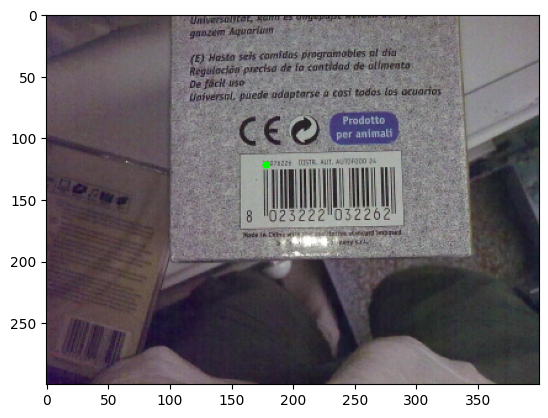

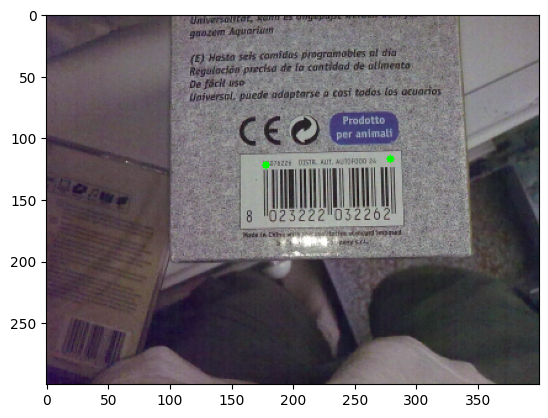

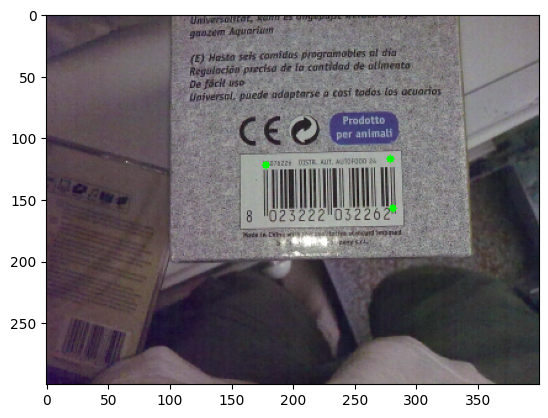

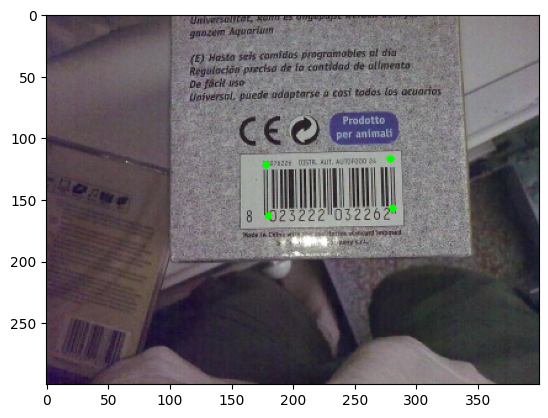

In [14]:
for i in box:
    cv2.circle(resized_image,(i[0],i[1]), 3, (0,255,0), -1)
    imgplot = plt.imshow(resized_image)
    plt.show()

Vamos a guardar la rotacion, altura y anchura para poner la imagen derecha

In [15]:
angulo = rect[2]
alto, ancho = resized_image.shape[0:2]
if angulo < -45:
    angulo = -(90 + angulo)
else:
    angulo = angulo - 90
matriz_rotacion = cv2.getRotationMatrix2D(rect[0], angulo, 1.0)
imagen_rotada = cv2.warpAffine(resized_image, matriz_rotacion, (ancho, alto))

Rotamos el área del dibujo del código de barras

In [16]:
pts_rotados = cv2.transform(np.array([box]), matriz_rotacion)[0]

cv2.drawContours(imagen_rotada, [pts_rotados], -1, (0, 255, 0), 3)
cv2.imshow("Contorno seleccionado", imagen_rotada)
cv2.waitKey(0)
cv2.destroyAllWindows()

Recortamos la imagen

In [17]:
# Bounding box tras rotar
xs = pts_rotados[:, 0]
ys = pts_rotados[:, 1]

# Cogemos las coordenadas minimas y maximas ya que sino la imagen recortada sale mal
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()

# Recortamos la imagen
imagen_recortada = imagen_rotada[y_min:y_max, x_min:x_max]

cv2.imshow("Imagen recortada", imagen_recortada)
cv2.waitKey(0)
cv2.destroyAllWindows()